In this notebook you will find the most complete applied guide to developing image classification algorithms using Neural Networks. I made myself sure to include the best practices relating the process of developing high accuracy classification algorithms. Everything is covered, from reviewing the data to deploying best practices. I hope you enjoy and learn lots, just as i did.

The goal of this project is to recognice hand gestures from the Alphabet in international sign language. This jupyter notebooks was inspired by the loyal work of my friend Janina, who's work life is focused on helping deaf people to live in a more inclusive society. 

Janina, if you ever read this, the world needs more people like you! ♥

## Needed libraries

In [26]:
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras import Model,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Add, Conv2D,ReLU, BatchNormalization,Dense, MaxPool2D, Dropout, Flatten, InputLayer
from keras.utils import plot_model
from keras.optimizers import Adam

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Importing Data and description

The dataset consists of images, each presented as a reshaped 1D vector version of the image, next to the corresponding category in the "label" column, which labels the sample with a number, ranging from 0 to 24, being 0 letter "A", 1 letter "B" and so on to letter "Y".


Note:   
    
Numbers 9 and 25 are not present in the dataset, which are the labels for letters "J" and "Z", respectively. The reason behind this is that both letters imply movement, impossible to identify with static images.

* Letter "J" is similar to letter i, implying a u-shape movement with the pinky finger

* Letter "Z" is somewhat drawn in the air using the index finger

In [2]:
# A simple mapping relating the label with its corresponding letter
mapping_dict = {}
value = 0
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    if letter in ["J", "Z"]:
        value += 1
        continue
    mapping_dict[letter] = value
    value += 1
inverted_dict = {v: k for k, v in mapping_dict.items()}

In [3]:
train_df = pd.read_csv("datasets/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("datasets/sign_mnist_test/sign_mnist_test.csv")

display("train_df: ", train_df.sample(5))

y_train = train_df[["label"]]
y_test = test_df[["label"]]
del train_df["label"]
del test_df["label"]

print("Labels: ", y_train.label.sort_values().unique())

'train_df: '

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
10389,7,191,191,192,193,192,192,193,193,192,...,171,183,185,193,198,197,176,182,174,152
19850,14,189,190,191,191,191,192,192,192,191,...,223,223,221,219,220,213,188,153,121,101
22852,6,109,111,112,115,118,120,122,123,125,...,160,160,160,160,160,159,160,158,156,155
12512,19,181,184,186,187,188,189,189,189,190,...,165,166,139,188,144,173,108,154,169,167
7387,17,167,169,170,170,171,172,172,172,172,...,109,70,123,191,179,180,178,177,175,173


Labels:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


Its important to check visually the differences between the datasets, as it may give an idea of the application context, where the algorithm will be deployed (test set) and how it differs from the available data for training (test set)


Visual comparisons are shown below:

note:

- No evident differences were identified between the training and test sets
- run the image plotting cells as much as you want if you want to check for yourself

#### Training set overview

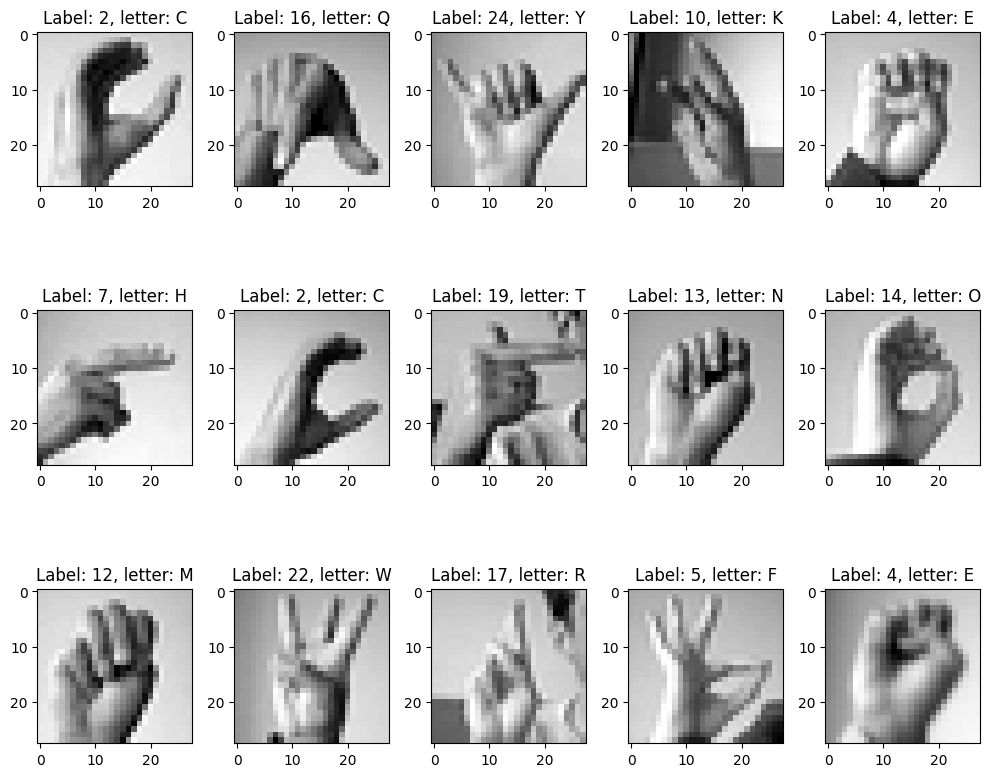

In [4]:
check_on = train_df.values.reshape(-1, 28, 28, 1)
label_on = y_train.values
n_rows = 3
n_cols = 5

f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0, label_on.shape[0])
        label = label_on[im_idx][0]
        ax[i, j].imshow(check_on[im_idx], cmap="gray")
        ax[i, j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()

#### Test set overview

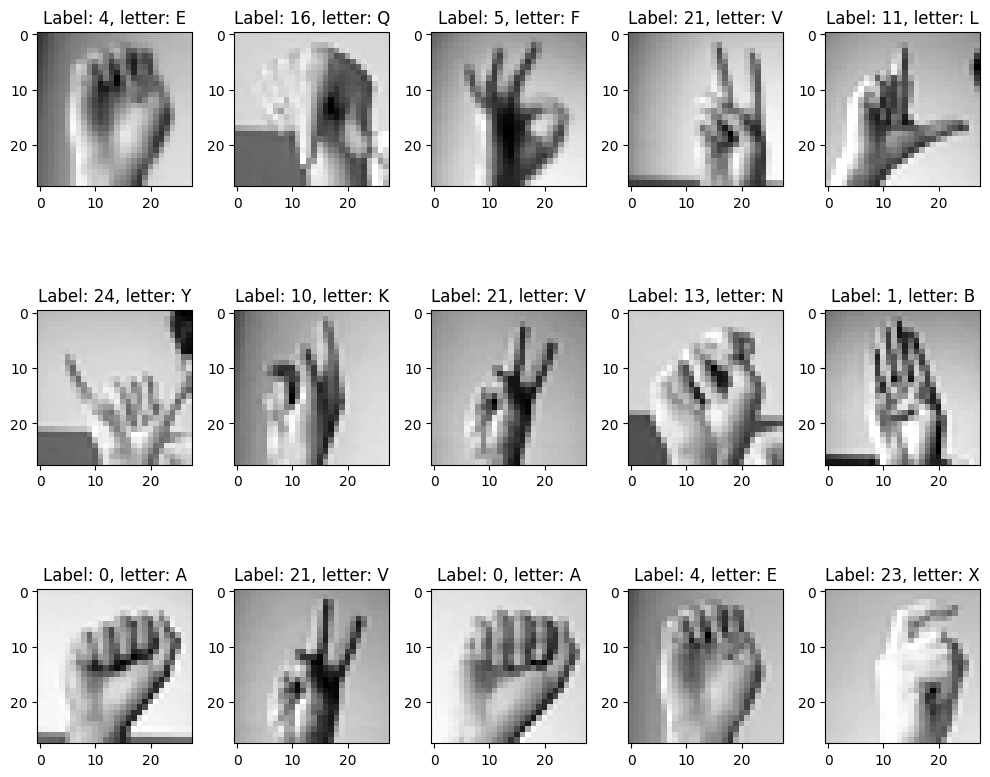

In [5]:
check_on = test_df.values.reshape(-1, 28, 28, 1)
label_on = y_test.values
n_rows = 3
n_cols = 5

f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0, label_on.shape[0])
        label = label_on[im_idx][0]
        ax[i, j].imshow(check_on[im_idx], cmap="gray")
        ax[i, j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()

#### Warning

By looking at the samples for a single letter, we would realize that all the letter samples were taken from right handed people. This is a problem since developing a model with this only data would exclude left handed people communicating with sign language.

Hint: 

- I asked my friend Janina, and he confirmed to me that the letter "C" for example should be equally recognized with the other hand, looking inversed , lookins like this: "Ↄ"

- This is easily solved later by randomly flipping the images horizontally during the training of the model.

Checking on letter C


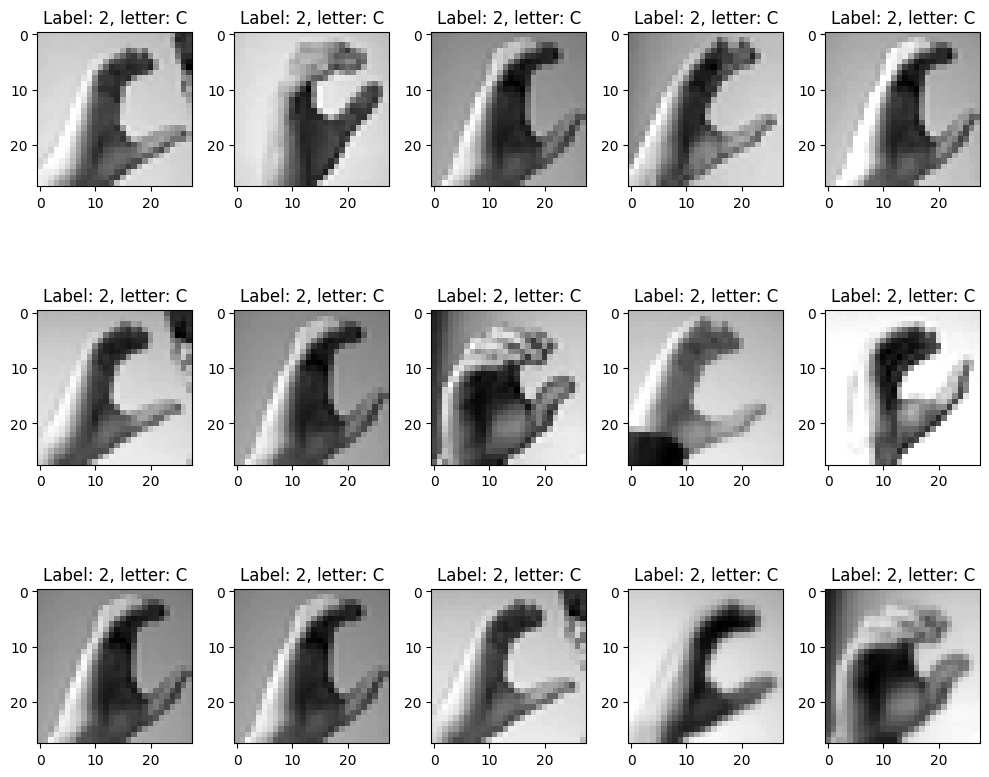

In [6]:
letter_check = "C"
letter_check_idx = mapping_dict[letter_check]
print(f"Checking on letter {letter_check}")
check_on = test_df[y_test.label == letter_check_idx].values.reshape(-1, 28, 28, 1)
label_on = y_test[y_test.label == letter_check_idx].values
n_rows = 3
n_cols = 5

f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0, label_on.shape[0])
        label = label_on[im_idx][0]
        ax[i, j].imshow(check_on[im_idx], cmap="gray")
        ax[i, j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()

## Data Balance

From the rounding 35000 of samples in total, 20% correspond to the training set, which seems appropriate

In [7]:
num_test = y_test.shape[0]
num_train = y_train.shape[0]

num_tot = num_test + num_train
print(f"Total number of samples: {num_tot}")
print(f"percentage of test samples: {100*num_test/num_tot:.2f}%")

Total number of samples: 34627
percentage of test samples: 20.71%


The distribution of categories appears relatively balanced between the training and test sets overall. However, upon closer examination of the bar graph below, it becomes evident that there is a discrepancy in the allocation of data for letters Q and R. Specifically, an imbalance is observed wherein a disproportionate number of samples have been assigned to the training set, while the test set is underrepresented for these particular letters compared to others.

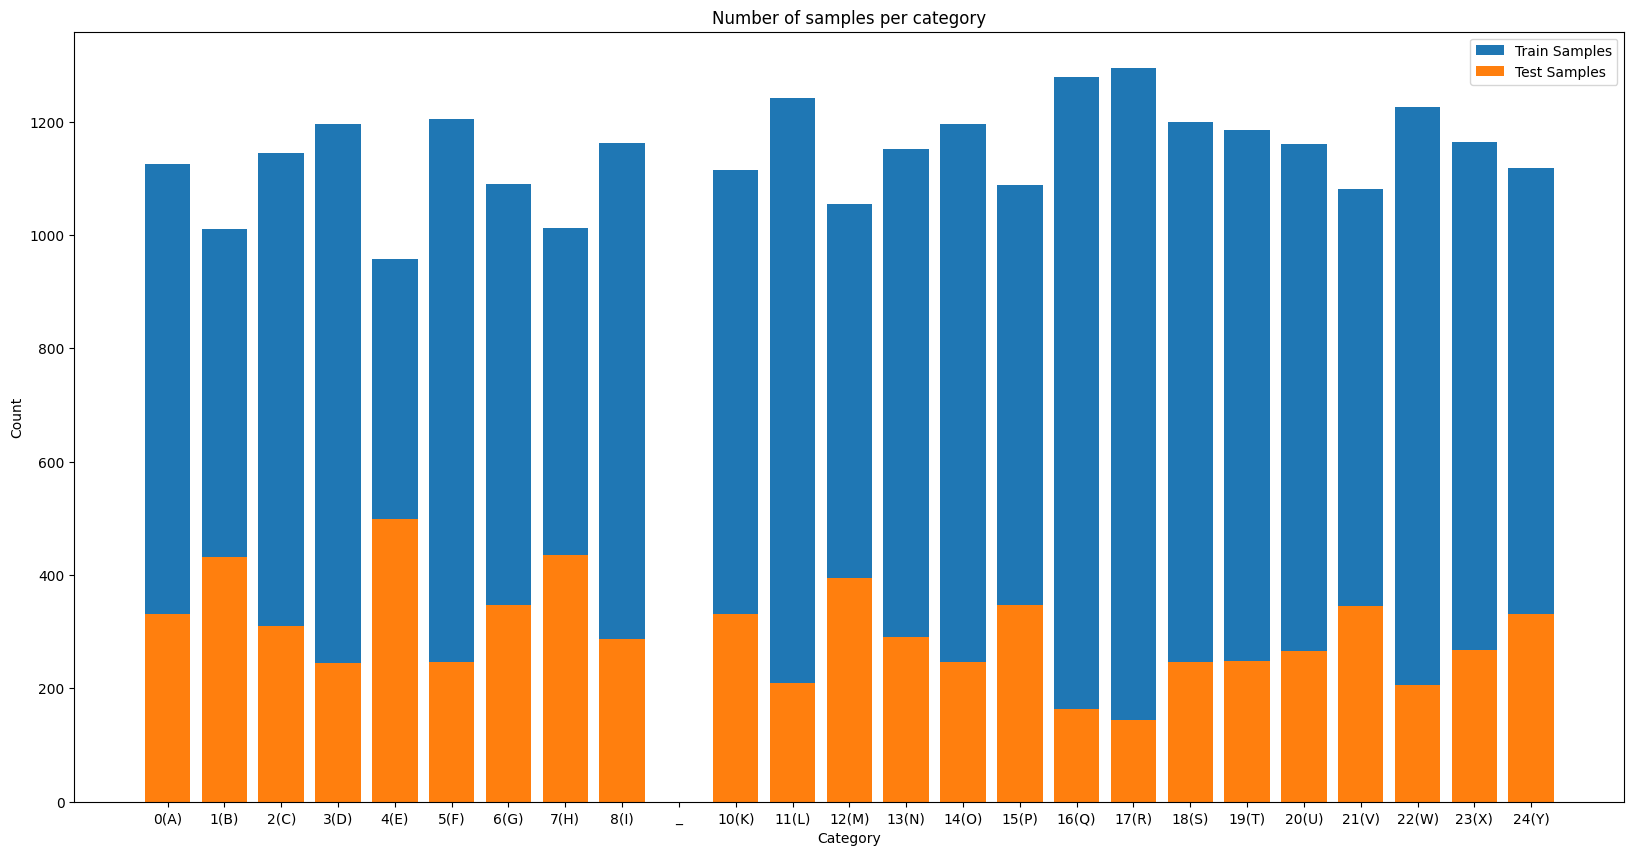

In [8]:
labels = sorted(y_train.label.unique())
labels = [f"{label}({inverted_dict[label]})" for label in labels]
labels = labels[:9] + ["_"] + labels[9:]
bins = len(labels)

plt.figure(figsize=(20, 10))

train_label_counts = y_train.label.value_counts()
plt.bar(train_label_counts.index, train_label_counts.values, label="Train Samples")
test_label_counts = y_test.label.value_counts()
plt.bar(test_label_counts.index, test_label_counts.values, label="Test Samples")

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of samples per category")
plt.xticks(range(len(labels)), labels)
plt.legend()

plt.show()

Given the imbalance found above, and since no there is not a special difference between the samples between the training and test samples (as to say that test set approaches more to the final application) both training and test sets will be merged, shuffled, and re-sampled. 

Additionally, I will introduce another dataset for hold-out cross validation (developement set) to decide on diverse hyperparameters and architectures. At the end we will have:

- Training set: For learning
- Dev set: For evaluating the performance of different CNN architectures and hyperparameters
- Test set: For evaluating the best developed model, identified using the dev set

The percentages defined for the splitting are:

Training set: 70%  for training

development set: 15%  To compare between different models and hyperparameters

Test set: 15%  To check final model's performance

In [9]:
full_df = pd.concat([train_df, test_df])
full_y = pd.concat([y_train, y_test])

# Reshape

# (each is a 28x28 pixel image)
num_pixels = int((full_df.shape[1]) ** (1 / 2))

x_full = full_df.values
x_full = x_full.reshape(-1, num_pixels, num_pixels, 1)

# Output as numpy array
y_full = full_y.values

# Splitting of the dataset
x_train, x_devtest, y_train, y_devtest = train_test_split(
    x_full, y_full, train_size=0.7, shuffle=True
)
x_dev, x_test, y_dev, y_test = train_test_split(
    x_devtest, y_devtest, test_size=0.5, shuffle=True
)
total_len = x_full.shape[0]
x_train_len = x_train.shape[0]
x_dev_len = x_dev.shape[0]
x_test_len = x_test.shape[0]
print(f"x_train percentage = {x_train_len/total_len:.02f}")
print(f"x_dev percentage = {x_dev_len/total_len:.02f}")
print(f"x_test percentage = {x_test_len/total_len:.02f}")

x_train percentage = 0.70
x_dev percentage = 0.15
x_test percentage = 0.15


Checking on data balance visually again.

Datasets are now much more balanced.

Note: dev and test set quantities overlaps since both represent equally 15% of the data

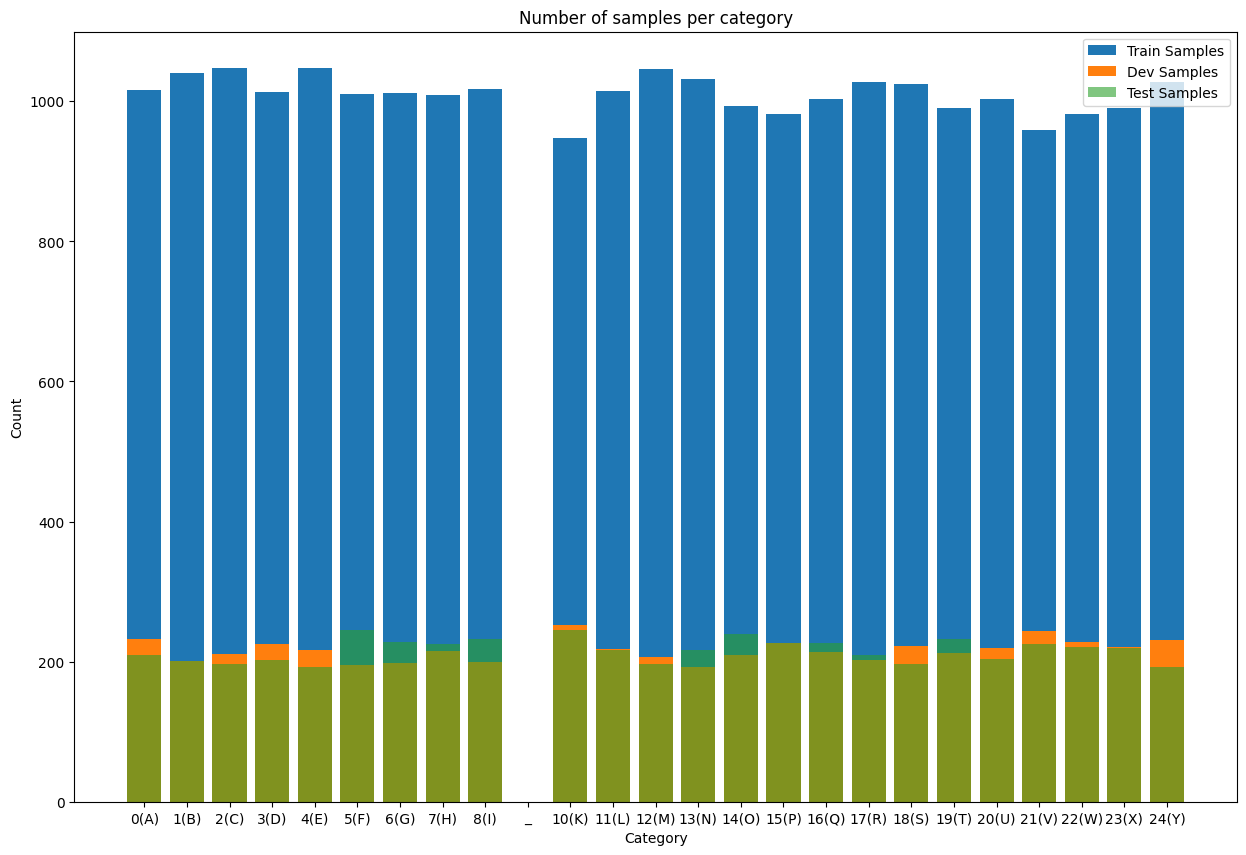

In [10]:
labels = sorted(np.unique(y_train))
labels = [f"{label}({inverted_dict[label]})" for label in labels]
labels = labels[:9] + ["_"] + labels[9:]
bins = len(labels)

plt.figure(figsize=(15, 10))

train_label_counts = pd.DataFrame(y_train).value_counts()
plt.bar(
    [idx[0] for idx in train_label_counts.index],
    train_label_counts.values,
    label="Train Samples",
)
dev_label_counts = pd.DataFrame(y_dev).value_counts()
plt.bar(
    [idx[0] for idx in dev_label_counts.index],
    dev_label_counts.values,
    label="Dev Samples",
)
test_label_counts = pd.DataFrame(y_test).value_counts()
plt.bar(
    [idx[0] for idx in test_label_counts.index],
    test_label_counts.values,
    label="Test Samples",
    alpha=0.6,
)


plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of samples per category")
plt.xticks(range(len(labels)), labels)
plt.legend()

plt.show()

## Training Hyperparameters

### Adjusting the data

#### One-hot ecoding

Its important to adjust the correct labeling for the output labels. 

In this case we have a numerical label for each hand posture, keeping it like this would imply that some gestures have more value than others, which is uncorrect.

This is fixed by one hot encoding the labels

In [11]:
# OUTPUT ENCODING

oh_encoder = OneHotEncoder()

y_train_oh = oh_encoder.fit_transform(y_train).toarray()
y_dev_oh = oh_encoder.fit_transform(y_dev).toarray()
y_test_oh = oh_encoder.fit_transform(y_test).toarray()

#### Data Augmentation

The training data is altered during learning to virtually augment the amount of samples, and also making the Neural network performance robust against variations. Its important to make these alterations considering real application scenarios. For example, in this particular case, you would not like to invert upside-down the images, unless you were developing a model to sign language communicate with bats ☻

Parameters selected for augmentation:

Slight rotation of 20%.

Width and height shift set to 10%

zoom range set to 10%

Brightness was set to range between +/- 25% 

The "fill_mode" parameter was chosen as "nearest" (fills with the nearest pixels), as there is not an important evident pattern to be learned in the images background.

A horizontal flip was included, since the same letters should be equally recognized when performed with the left or the right hand (inclusion means also considering left handed people, or even individuals with missing extremities)

Vertical flip is set to False, since upside down sign communication is not quite a common thing :) 

Note:
- ImageDataGenerator.fit(x_full) is used to compute and store statistics necessary for data normalization and augmentation, which helps in efficient data processing during training


In [12]:
# Data Augmentation for training

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.75, 1.25),
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=False,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
    x_train,  # Input numpy array of images
    y_train_oh,  # Corresponding labels
    batch_size=64,  # Batch size
    shuffle=True,  # Shuffle the data
)

# Data Augmentation for cross-out validation

dev_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
)

dev_datagen.fit(x_dev)

dev_generator = dev_datagen.flow(
    x_dev,  # Input numpy array of images
    y_dev_oh,  # Corresponding labels
    batch_size=64,  # Batch size
    shuffle=True,  # Shuffle the data
)


# Data Augmentation for testing

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
)

test_datagen.fit(x_test)

test_generator = test_datagen.flow(
    x_test,  # Input numpy array of images
    y_test_oh,  # Corresponding labels
    batch_size=64,  # Batch size
    shuffle=True,  # Shuffle the data
)

##### Checking visually the image transformations

{'theta': -10.546783013283324,
 'tx': -0.05738818938061925,
 'ty': -0.11167796962856152,
 'shear': 0,
 'zx': 1.062806017841491,
 'zy': 0.9676859276088875,
 'flip_horizontal': 0,
 'flip_vertical': 0,
 'channel_shift_intensity': None,
 'brightness': 0.787875497139592}

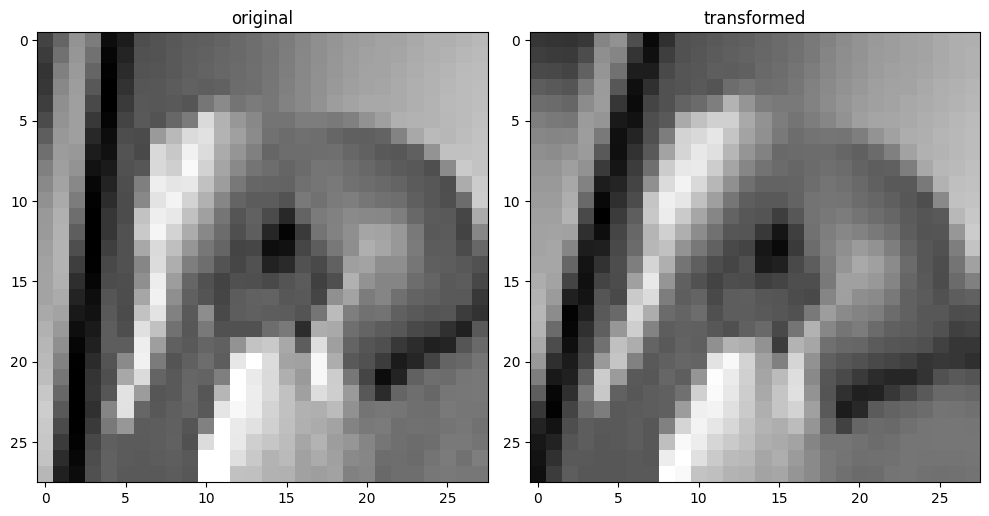

In [13]:
# Checking in the transformations specified
random_img = np.random.randint(0, x_full.shape[0])
img_sample = x_full[random_img]
img_sample_reshaped = np.expand_dims(img_sample, axis=0)
transform_parameters = train_datagen.get_random_transform(img_sample_reshaped.shape)
trans_img = train_datagen.apply_transform(img_sample_reshaped[0], transform_parameters)

display(transform_parameters)

n_rows = 1
n_cols = 2
f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
ax[0].imshow(img_sample, cmap="gray")
ax[0].set_title("original")
ax[1].imshow(trans_img, cmap="gray")
ax[1].set_title("transformed")
plt.tight_layout()

#### Defining regularization and training-speeding techniques

- ReduceLROnPlateau: Known as Learning Rate Decay, reduces the learning rate after certain number of epochs of no relevant performance enhancement
- EarlyStopping: Stop training after certain number of epochs of no relevant performance enhancement, keeping the best previous performance weights
- L2 regularization: modification of the cost function to reduce the amount of weight added to the neurons, avoiding overfitting.
- Dropout: modification of the cost function to reduce the amount of weight added to the neurons, avoiding overfitting.

    - note: the Regularization and Dropout parameters will be initially set to a low value, then it can be increased in accordance to the amount of overfitting observed.

- Learning rate: for the Adam optimizer, the learning rate will be se initially high. This is then automatically adjusted with the rearning rate decay



In [29]:
reduce_lr = ReduceLROnPlateau(
    monitor="loss", patience=2, factor=0.5, min_lr=0.00001, verbose=1
)
early_stopping = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True,verbose=1)

l2_regularization = tf.keras.regularizers.l2(0.00001)

dropout_rate = 0.001
learning_rate = 0.01

## Defining the model architecture

With the intention of presenting an overview of a good Machine Learning strategy, 3 different models were defined, trained, and tested using the development set, with which the hyperparameters are tuned for further enhancement. The best among those those models is later to be faced against the testing dataset.

These 3 models differ in its implementation:

1. Involves TensorFlow's sequential model
2. Involves TnsorFlow's Functional API for establishing a simplistic version of a CNN using skipped connections
3. Transfer learning using the old reliable LeNet-5 (originally designed for identifying handwritten characters) for transfer learning

### Sequential Model

#### Models architecture

This architecture was inspired in the classic LeNet-5, which was originally developed to recognize 32x32 greyscale 0-9 handwritten digit images.

In [15]:

def sequential_model(input_shape):

    model = Sequential()

    model.add(InputLayer(input_shape=input_shape))
    model.add(
        Conv2D(
            filters=6,
            kernel_size=(5, 5),
            strides=(1, 1),
            padding="valid",
            kernel_initializer="he_uniform",
            kernel_regularizer=l2_regularization,
        )
    )
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=2))
    model.add(
        Conv2D(
            filters=16,
            kernel_size=(5, 5),
            strides=(1, 1),
            padding="valid",
            kernel_initializer="he_uniform",
            kernel_regularizer=l2_regularization,
        )
    )
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(24, activation="softmax", kernel_regularizer=l2_regularization))

    return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 re_lu_24 (ReLU)             (None, 24, 24, 6)         0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 12, 12, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 re_lu_25 (ReLU)             (None, 8, 8, 16)          0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 4, 4, 16)          0         
 ng2D)                                               

None

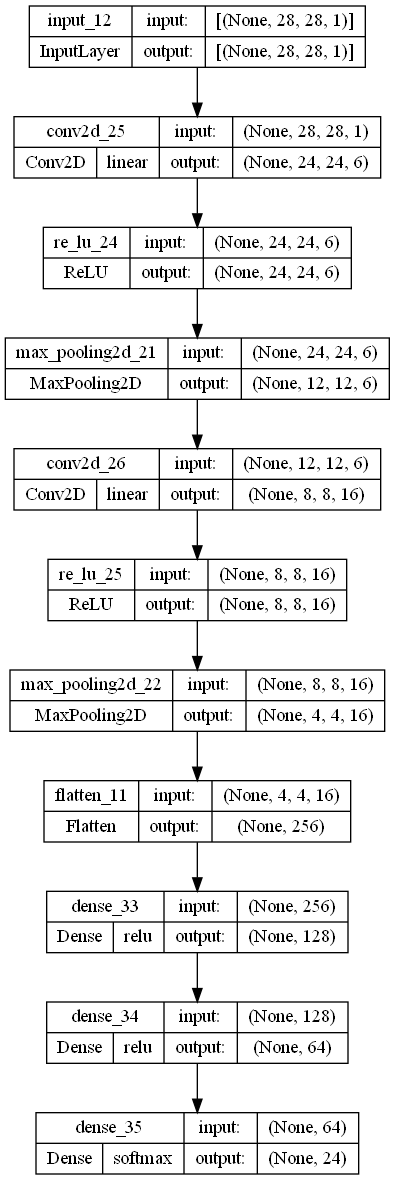

In [48]:
seq_model = sequential_model((num_pixels, num_pixels, 1))
adam_optimizer = Adam(learning_rate)
seq_model.compile(
    optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
display(seq_model.summary())
plot_model(
    seq_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
)

#### Training

In [82]:
train = False
resume_last_checkpoint = True


model_path = "saved_models/seq_model.keras"
model_exists = os.path.exists(model_path)
if not model_exists or train:

    checkpoint_path = "checkpoints/seq_model_checkpoint/seq_model.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    monitor='val_accuracy',
                                                    save_weights_only=True,
                                                    verbose=1)
    if resume_last_checkpoint:
        latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
        seq_model.load_weights(latest_cp)


    history = seq_model.fit(
        train_generator,
        validation_data=dev_generator,
        epochs=30,
        batch_size=64,
        callbacks=[reduce_lr, early_stopping,cp_callback],
    )


#### Evaluation

In [88]:
if model_exists:
    if train:
        prev_seq_model = tf.keras.models.load_model('saved_models/seq_model.keras')
        loss_p, accuracy_p = prev_seq_model.evaluate(dev_generator)
        print(f"Previously stored seq_model gives {loss_p} loss and {accuracy_p} accuracy on the dev set")

        loss, accuracy = seq_model.evaluate(dev_generator)
        print(f"Newly trained model seq_model gives {loss} loss and {accuracy} accuracy on the dev set")
        if accuracy > accuracy_p:
            print("New models performance accuracy beats the previous model's one.\nModel gets updated")
            prev_seq_model.save('saved_models/seq_model.keras')
        else:
            print("Previous models performance accuracy beats the new model's one.\nModel remains the same")
            seq_model = prev_seq_model
    else:
        seq_model = tf.keras.models.load_model('saved_models/seq_model.keras')
        loss, accuracy = seq_model.evaluate(dev_generator)
        print(f"Previously stored model seq_model gives {loss} loss and {accuracy} accuracy on the dev set")
else:
    loss, accuracy = seq_model.evaluate(dev_generator)
    print(f"Newly trained model seq_model gives {loss} loss and {accuracy} accuracy on the dev set")
    seq_model.save('saved_models/seq_model.keras')

82/82 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.9782
Previously stored model seq_model gives 0.0659220963716507 loss and 0.9782441258430481 accuracy on the dev set


In [89]:
if train:
    df_loss_acc = pd.DataFrame(history.history)
    df_loss = df_loss_acc[["loss", "val_loss"]]
    df_loss = df_loss.rename(columns={"loss": "train", "val_loss": "validation"})
    df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
    df_acc = df_acc.rename(columns={"accuracy": "train", "val_accuracy": "validation"})
    df_loss.plot(title="Model loss", figsize=(20, 10)).set(xlabel="Epoch", ylabel="Loss")
    df_acc.plot(title="Model Accuracy", figsize=(20, 10)).set(
        xlabel="Epoch", ylabel="Accuracy"
    )

### Functional API model

#### Models architecture


This model employs TensorFlow's Functional API to construct a simplified skip connection architecture. It comprises two consecutive blocks:

- A convolutional block, where the skip connection incorporates a convolution operation.
- An identity block, wherein the skip connection is directly added to the primary path.

In [20]:
def convolutional_block(X):
    X_shortcut = X
    X = Conv2D(
        filters=16,
        kernel_size=4,
        strides=1,
        padding="same",
        kernel_initializer="he_uniform",
        kernel_regularizer=l2_regularization,
    )(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    X = Conv2D(
        filters=32,
        kernel_size=4,
        strides=1,
        padding="same",
        kernel_initializer="he_uniform",
        kernel_regularizer=l2_regularization,
    )(X)
    X = BatchNormalization()(X)
    # SHORTCUT PATH INVOLVING A CONV LAYER

    X_shortcut = Conv2D(
        filters=32,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_uniform",
    )(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X


def identity_block(X):
    X_shortcut = X
    X = Conv2D(
        filters=16,
        kernel_size=4,
        strides=1,
        padding="same",
        kernel_initializer="he_uniform",
        kernel_regularizer=l2_regularization,
    )(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    X = Conv2D(
        filters=32,
        kernel_size=4,
        strides=1,
        padding="same",
        kernel_initializer="he_uniform",
        kernel_regularizer=l2_regularization,
    )(X)
    X = BatchNormalization()(X)
    # DIRECT SHORTCUT PATH
    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X


def skip_connections_model(input_shape):


    input_img = tf.keras.Input(shape=input_shape)

    X = convolutional_block(input_img)

    X = identity_block(X)
    X = MaxPool2D()(X)
    X = Flatten()(X)
    X = Dense(128, activation="relu")(X)
    X = Dense(64, activation="relu")(X)
    outputs = Dense(units=24, activation="softmax")(X)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 28, 28, 16)           272       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 16)           64        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu_2 (ReLU)              (None, 28, 28, 16)           0         ['batch_normalization[0][0

None

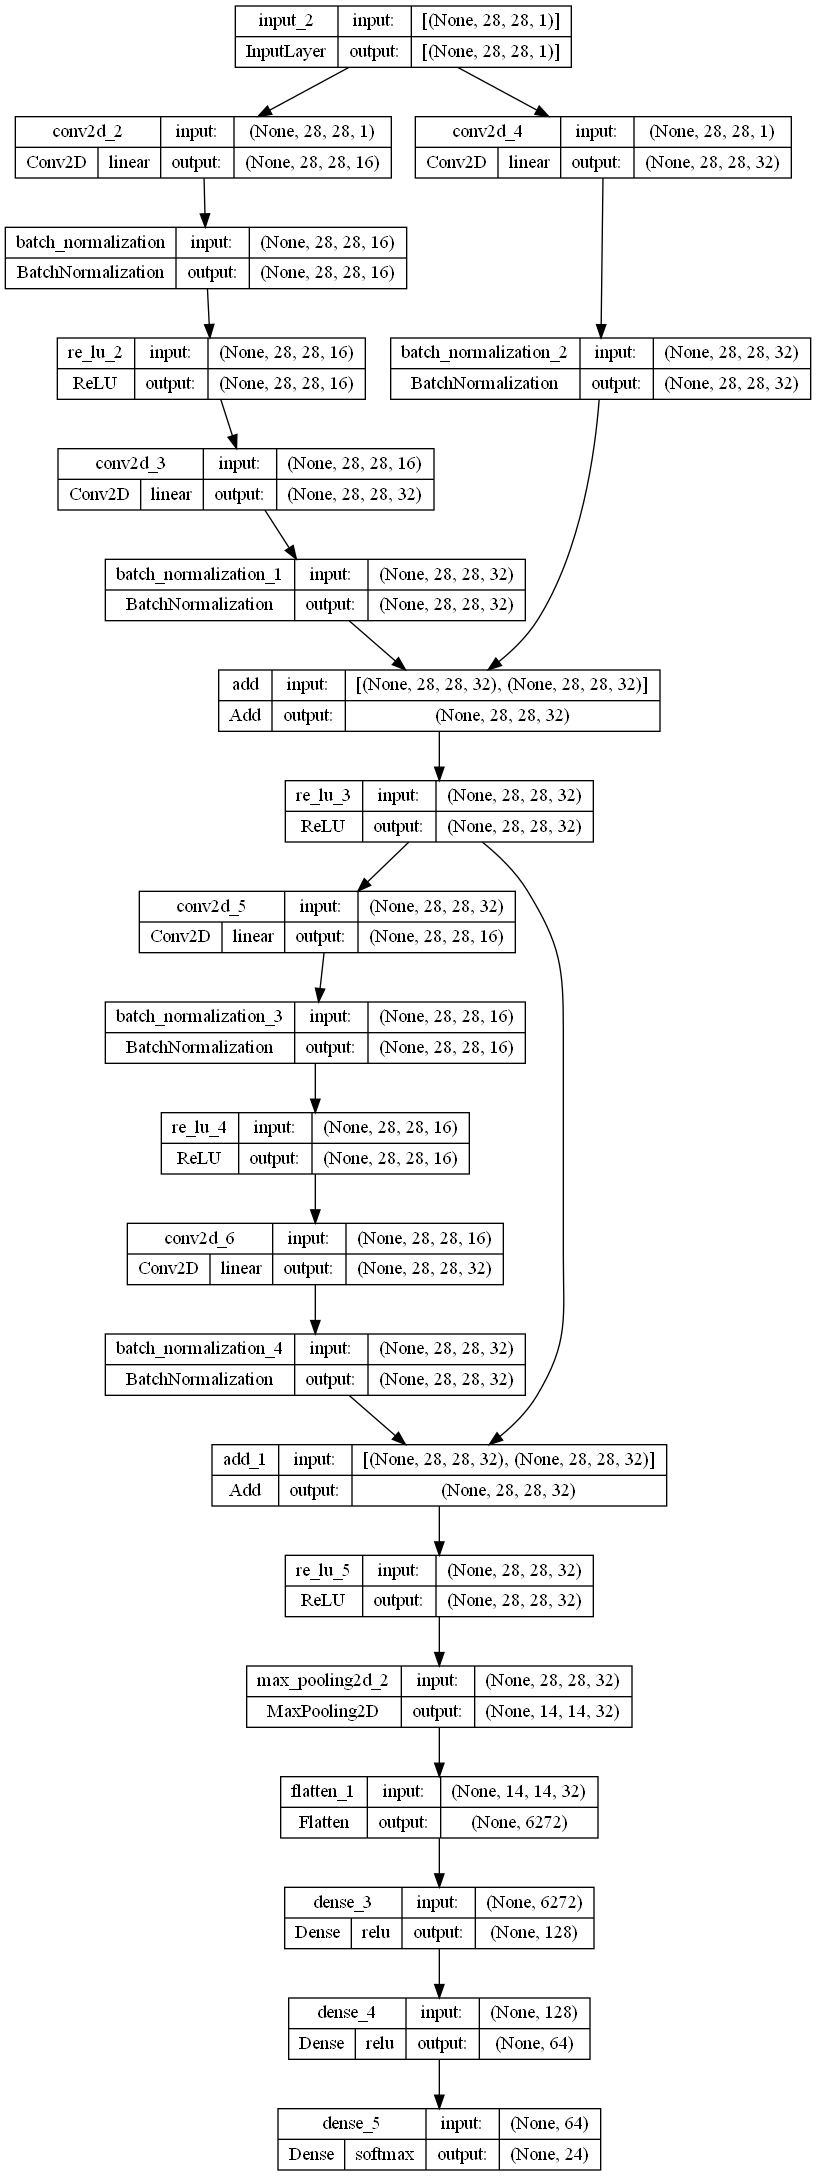

In [21]:
skip_model = skip_connections_model((num_pixels, num_pixels, 1))
adam_optimizer = Adam(learning_rate)
skip_model.compile(
    optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
display(skip_model.summary())
plot_model(
    skip_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
)

#### Training

In [22]:
history = skip_model.fit(
    train_generator,
    validation_data=dev_generator,
    epochs=30,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/30


379/379 [==============================] - 23s 56ms/step - loss: 4.0435 - accuracy: 0.0431 - val_loss: 3.1828 - val_accuracy: 0.0447 - lr: 0.0100
Epoch 2/30
379/379 [==============================] - 21s 56ms/step - loss: 3.1825 - accuracy: 0.0405 - val_loss: 3.1840 - val_accuracy: 0.0406 - lr: 0.0100
Epoch 3/30
379/379 [==============================] - 22s 58ms/step - loss: 3.1827 - accuracy: 0.0399 - val_loss: 3.1830 - val_accuracy: 0.0399 - lr: 0.0100
Epoch 4/30
378/379 [============================>.] - ETA: 0s - loss: 3.1827 - accuracy: 0.0405
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
379/379 [==============================] - 21s 55ms/step - loss: 3.1827 - accuracy: 0.0405 - val_loss: 3.1823 - val_accuracy: 0.0420 - lr: 0.0100
Epoch 5/30
379/379 [==============================] - 21s 55ms/step - loss: 3.1819 - accuracy: 0.0404 - val_loss: 3.1824 - val_accuracy: 0.0416 - lr: 0.0050
Epoch 6/30
379/379 [==============================] - 21s 55ms/ste

#### Evaluation

In [23]:
loss, accuracy = skip_model.evaluate(dev_generator)
print(f"Model skip_model gives {loss} loss and {accuracy} accuracy")

 4/82 [>.............................] - ETA: 1s - loss: 3.1814 - accuracy: 0.0430

82/82 [==============================] - 2s 18ms/step - loss: 3.1796 - accuracy: 0.0399
Model skip_model gives 3.179563522338867 loss and 0.03985367715358734 accuracy


In [24]:
tf.saved_model.save(skip_model, 'skip_model')
loaded_model = tf.saved_model.load('skip_model/saved_model.pb')
loss, accuracy = loaded_model.evaluate(dev_generator)
print(f"Model skip_model gives {loss} loss and {accuracy} accuracy")

INFO:tensorflow:Assets written to: skip_model\assets


INFO:tensorflow:Assets written to: skip_model\assets


OSError: SavedModel file does not exist at: skip_model/saved_model.pb\{saved_model.pbtxt|saved_model.pb}

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

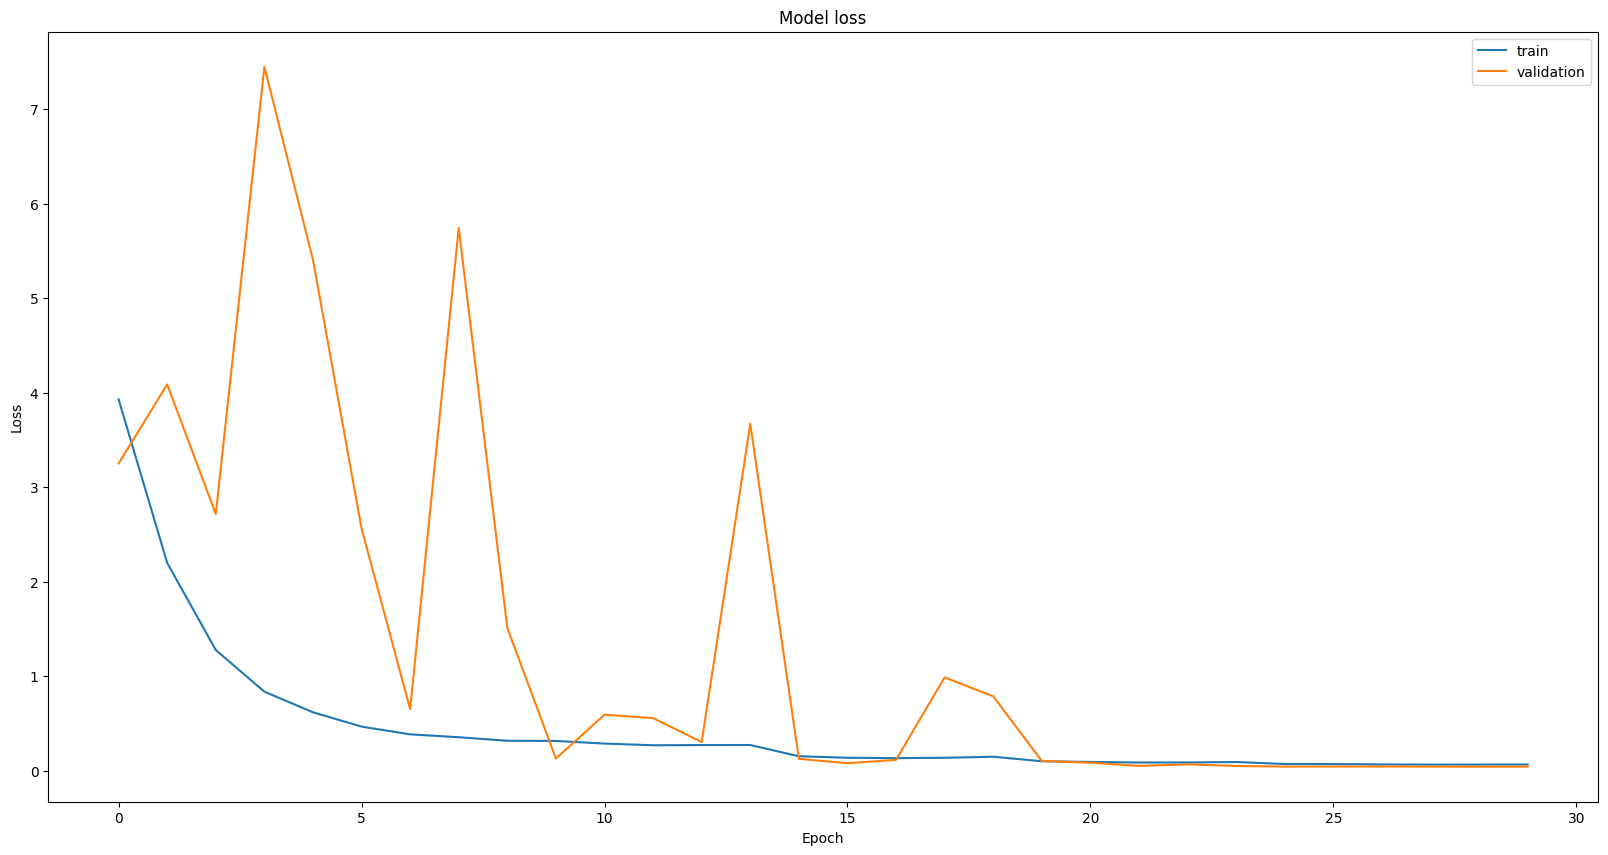

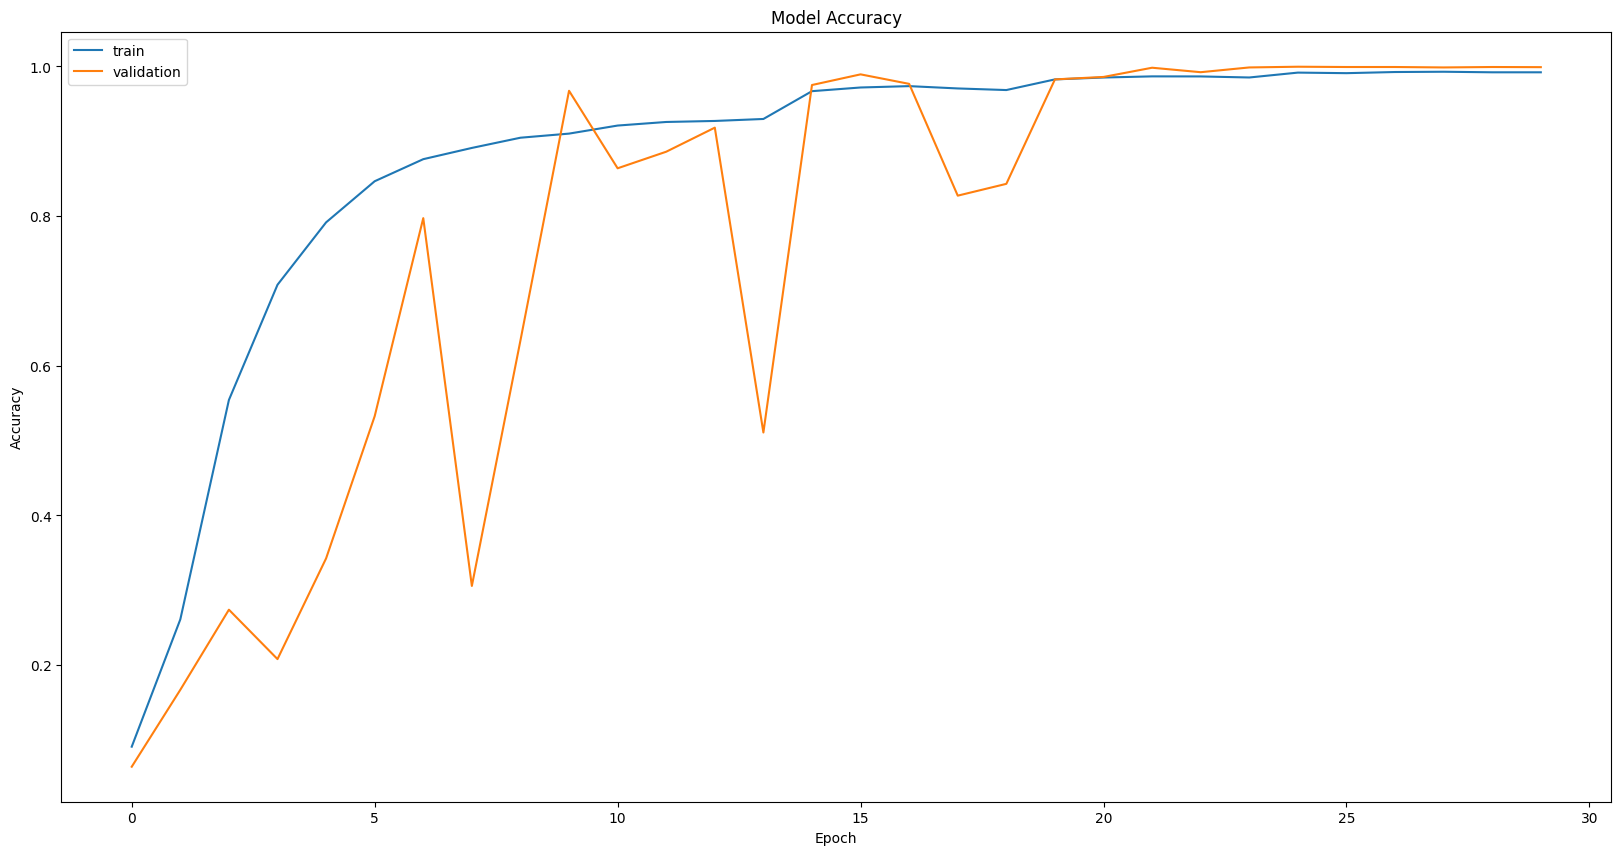

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss = df_loss.rename(columns={"loss": "train", "val_loss": "validation"})
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc = df_acc.rename(columns={"accuracy": "train", "val_accuracy": "validation"})
df_loss.plot(title="Model loss", figsize=(20, 10)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model Accuracy", figsize=(20, 10)).set(
    xlabel="Epoch", ylabel="Accuracy"
)

### Transfer Learning

#### Models architecture

This approach leverages the pretrained weights of "MobileNetV2" for the image classification task. To adapt "MobileNetV2" for this specific task, the top layer is substituted with a densely connected layer containing 24 neurons. Moreover, as the dataset comprises greyscale images while "MobileNetV2" expects RGB inputs, a preprocessing step is imperative to ensure compatibility with the model's input requirements.

In [ ]:


def transfer_model(input_shape):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(32,32,3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    
    input_img = tf.keras.Input(shape=input_shape) 
    resized_img = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (32, 32)))(input_img)
    overlapped_img = tf.keras.layers.Concatenate(axis=-1)([resized_img, resized_img, resized_img])

    preprocessed_img = preprocess_input(overlapped_img)
    X = base_model(preprocessed_img, training=False)
    X = tf.keras.layers.GlobalAveragePooling2D()(X) 
    X = tf.keras.layers.Flatten()(X)
    outputs = tf.keras.layers.Dense(units=24, activation="softmax")(X)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
transf_model = transfer_model((28, 28, 1))
adam_optimizer = Adam(learning_rate)
transf_model.compile(
    optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
display(transf_model.summary())
plot_model(
    transf_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
)

NameError: name 'transfer_model' is not defined

#### Training

In [ ]:
history = transf_model.fit(
    train_generator,
    validation_data=dev_generator,
    epochs=300,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/300


379/379 [==============================] - 17s 44ms/step - loss: 2.7923 - accuracy: 0.1574 - val_loss: 2.6839 - val_accuracy: 0.1977 - lr: 0.0100
Epoch 2/300
379/379 [==============================] - 16s 42ms/step - loss: 2.7960 - accuracy: 0.1551 - val_loss: 2.6697 - val_accuracy: 0.2033 - lr: 0.0100
Epoch 3/300
379/379 [==============================] - ETA: 0s - loss: 2.7951 - accuracy: 0.1564
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
379/379 [==============================] - 14s 37ms/step - loss: 2.7951 - accuracy: 0.1564 - val_loss: 2.6650 - val_accuracy: 0.2050 - lr: 0.0100
Epoch 4/300
379/379 [==============================] - 15s 39ms/step - loss: 2.7857 - accuracy: 0.1573 - val_loss: 2.6531 - val_accuracy: 0.2056 - lr: 0.0050
Epoch 5/300
379/379 [==============================] - 15s 39ms/step - loss: 2.7836 - accuracy: 0.1626 - val_loss: 2.6490 - val_accuracy: 0.2129 - lr: 0.0050
Epoch 6/300
379/379 [==============================] - 15s 39m

#### Evaluation

In [ ]:
loss, accuracy = transf_model.evaluate(dev_generator)
print(f"Model skip_model gives {loss} loss and {accuracy} accuracy")

 1/82 [..............................] - ETA: 10s - loss: 2.6232 - accuracy: 0.2344

82/82 [==============================] - 3s 34ms/step - loss: 2.6255 - accuracy: 0.2264
Model skip_model gives 2.6254870891571045 loss and 0.22641509771347046 accuracy


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

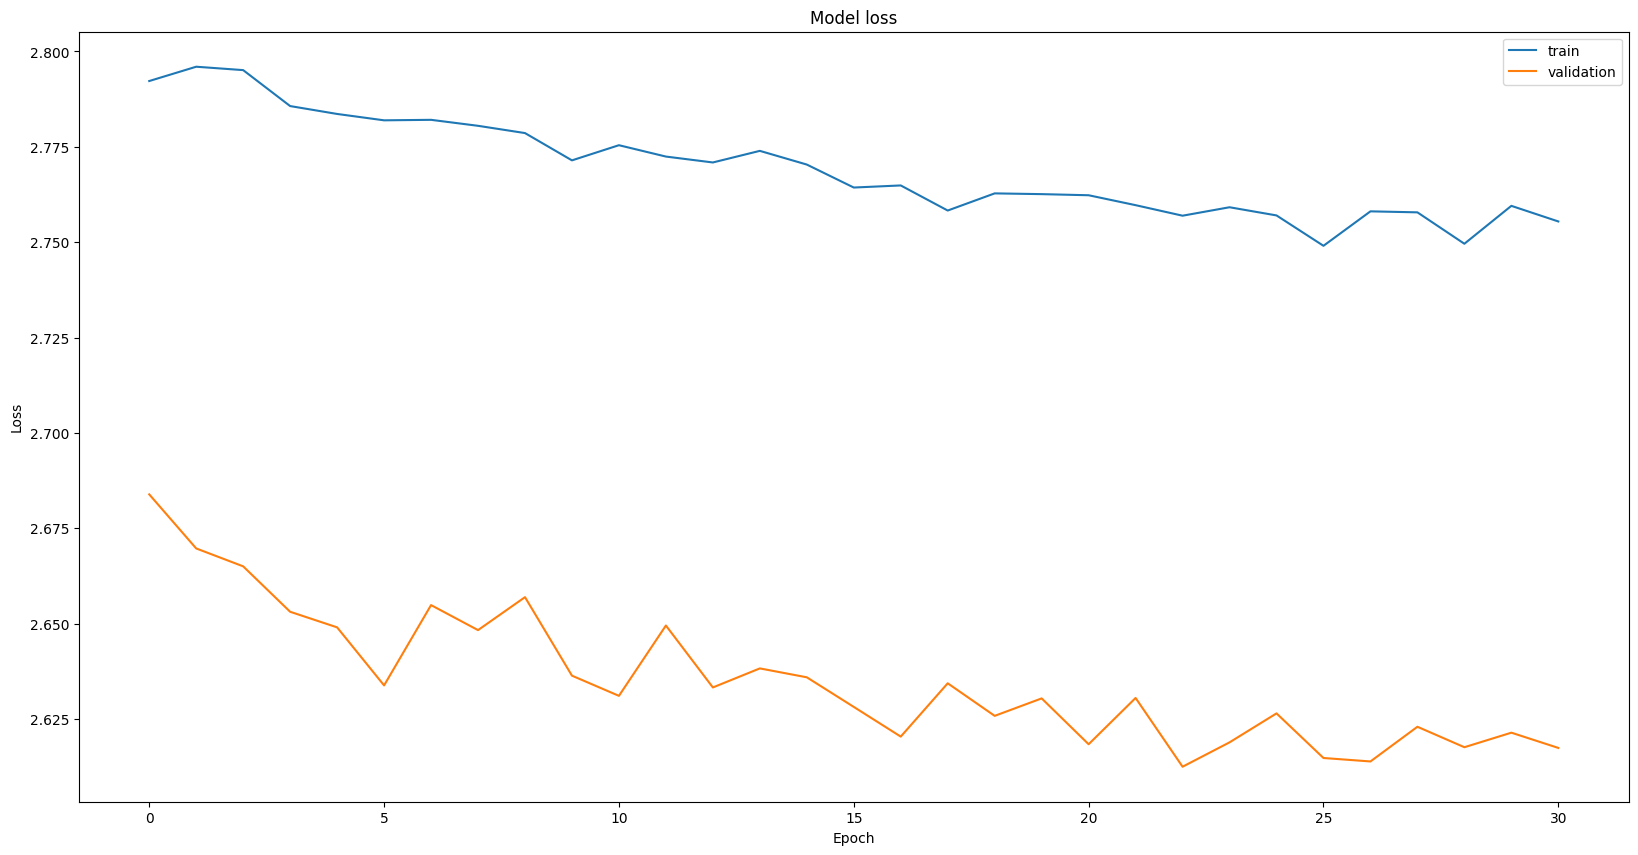

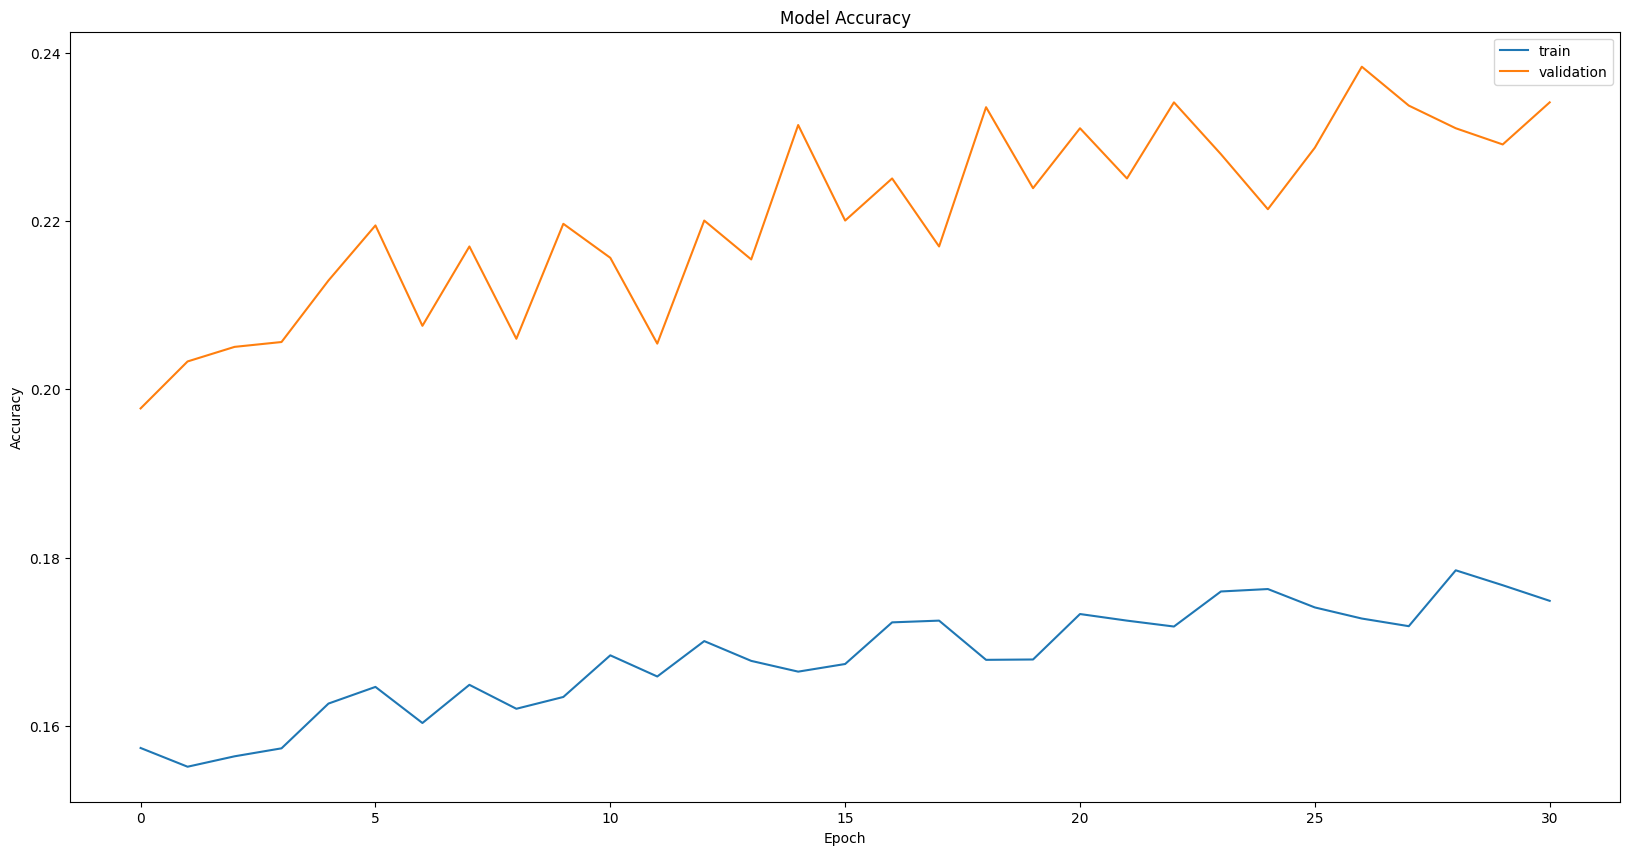

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss = df_loss.rename(columns={"loss": "train", "val_loss": "validation"})
df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc = df_acc.rename(columns={"accuracy": "train", "val_accuracy": "validation"})
df_loss.plot(title="Model loss", figsize=(20, 10)).set(xlabel="Epoch", ylabel="Loss")
df_acc.plot(title="Model Accuracy", figsize=(20, 10)).set(
    xlabel="Epoch", ylabel="Accuracy"
)